# Kalman Filter Example

This is an example implementation of a Kalman filter in Python.  Nothing fancy, all arithmetic is based around the `numpy` `matrix` methods.  The purpose of this example is to familiarize the reader with the information that needs to be known about the problem in order to set it up, how to implement it, and some idea of what the results could be like when graphed.  We will also explore two common measures of the error, the root mean squared error (RMSE) and the normalized innovation squared (NIS) error.

First we will define some constants and variables germane to our problem, ignoring state control.

In [1]:
import numpy as np


# Initial state 
x = np.matrix([[0.0], 
               [0.0]]) 

# Initial process covariance
P = np.matrix([[1000.0, 0.0], 
               [0.0,    1000.0]]) 

# State function (e.g. time step is one)
F = np.matrix([[1.0, 1.0], 
               [0.0, 1.0]])

# Measurement function
H = np.matrix([[1.0, 0.0]]) 

# Measurement uncertainty
R = np.matrix([[10.0]])

# Process uncertainty
Q = np.matrix([[0.0],
               [0.0]])

# Identity matrix
I = np.matrix([[1.0, 0.0], 
               [0.0, 1.0]]) 


Next we will create a function that updates the filter.  This is bound by the equations for the Kalman filter:

### **Prediction:**

 <img style="float: left;" src="../images/predicted_state_estimate.svg" />
 <div style="clear: both;" />
 <img style="float: left;" src="../images/predicted_estimate_covariance.svg" />
 <div style="clear: both;" />
 <br>

### **Measurement:**

 <img style="float: left;" src="../images/innovation_residual.svg" />
 <div style="clear: both;" />
 <img style="float: left;" src="../images/innovation_covariance.svg" />
 <div style="clear: both;" />
 <img style="float: left;" src="../images/optimal_kalman_gain.svg" />
 <div style="clear: both;" />
 <img style="float: left;" src="../images/update_state_estimate.svg" />
 <div style="clear: both;" />
 <img style="float: left;" src="../images/updated_covariance_estimate.svg" />
 

In [2]:
def filter_step(x, P, m):
    # Prediction
    x = F * x             # A priori state (u is zero in this case)
    P = F * P * F.T + Q   # A priori covariance
    
    # Measurement:
    z = np.matrix(m)      # Measurement
    y = z - H * x         # Innovation residual
    S = H * P * H.T + R   # Innovation covariance
    K = P * H.T * S.I     # Optimal Kalman gain
    x = x + K * y         # A posteriori state
    P = (I - K * H) * P   # A posteriori covariance
    
    # NIS:
    n = y.T * S.I * y
    
    return x, P, n

Next we use our filter.  First we will make a support that is essentially constant time increments to be used for plotting in the `x` axis.  We will generate quite noisy signals based on this.  The model we are using assumes we have some sort of constant velocity (with error), so we will be making that our assumption.  We simply add Gaussian noise scaled to the support for our noisy signal.  Finally we go through these measurements and compute the estimated Kalman position state for each step.  And plot the noisy measurement and the filtered state values.  We are also going to calculate the normalized innovation squared value for each point, as it is more useful to do this at this stage, even though we are going to evaluate it last in this notebook.

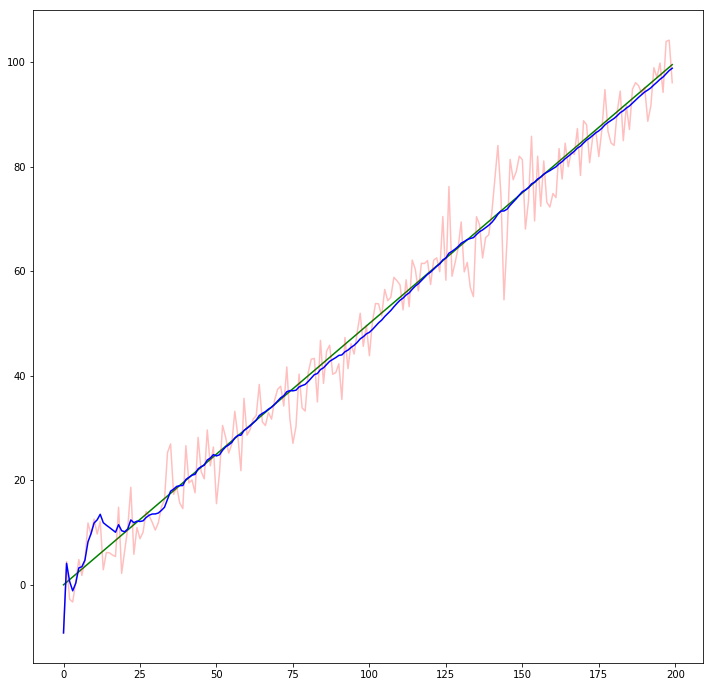

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,12))

# Define our support 
support = range(200)

# Make some noisy measurements
measurements = []
ground_truth = []
for i in support:
    gt = float(i) / 2.0
    ground_truth.append(gt)
    noisy = np.random.normal(gt, 5.0)
    measurements.append(noisy)

# Run the filter and collect ground truth and filter values
filter_vals = []
NIS = []
for z in measurements:
    x, P, n = filter_step(x, P, z)
    filter_vals.append(x[0].getA1()[0])
    NIS.append(n.getA1()[0])
    
# Plot it
plt.plot(support, ground_truth, color='g')
plt.plot(support, measurements, color='r', alpha=0.25)
plt.plot(support, filter_vals, color='b')
plt.show()

Interesting steps to take at this point are to vary the measurement and process uncertainties `R` and `Q` and see what happens to the filter as it tracks the measurement data.  For example, if you adjust `Q` to some non-zero vector, leeway will exist for the model to more closely track the noisy data.  This may or may not be what you want, it is something determined by the problem and your expectations.

To determine the RMSE, you simply sum up the square of the differences between the ground truth value (green line) and the filter position states (blue line), divide by the number of points, and take the square root.

In [4]:
total = 0.0
for i in range(len(ground_truth)):
    gt = ground_truth[i]
    kf = filter_vals[i]
    total += (gt - kf)**2
    
rmse = math.sqrt(total / len(ground_truth))

print(rmse)

1.54702839657


The RMSE is not normalized to anything.  If the data is small, the RMSE is small.  If the data is large, the RMSE is large.  You really need to understand what the filter is doing, where an appopriate region is to measure the RMSE, what the RMSE is actually telling you, and how that matters to your problem.

The other type of error that is commonly used is the normalized innovation squared, or NIS, error.  We calculated the NIS for each estimated measurement while we were evaluating the filter.  Let's plot this and see what it looks like.

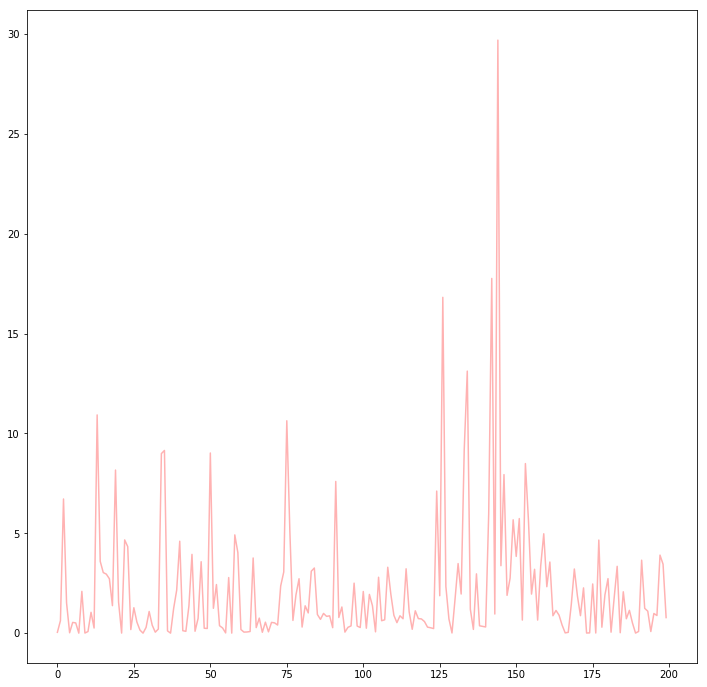

In [5]:
plt.figure(figsize=(12,12))

plt.plot(support, NIS, color='r', alpha=0.3)
plt.show()

The NIS for each point is essentially the square of the innovation conditioned by the innovation covariance.  This is a normalized value that assumes an underlying Guassian residual (in this case, since we based our arithmetic around Gaussian noise).  Consequently, the NIS admits a Chi squared distribution.  This means is that you can base your assessment of the model on standard Chi squared tables for the number of degrees of freedom of your implementation. 

If you were to look, for example, at a 95% confidence level for one degree of freedom, you would find that to be a value of 3.841 in the Chi squared tables.  For the NIS to show that the model is fitting for this hypothesis, you would want the bulk of your NIS scores to fall below this value.  In this particular case, this is fairly marginal, so we might either look at some other confidence level or reject the model and adjust the parameters.